In [1]:
# general libraries
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# visualization
import seaborn as sns
import matplotlib.pyplot as plt


### Data Prep

In [2]:
# cc_fraud = pd.read_csv('../data/full_fraud_dataset.csv',nrows=100000)
cc_fraud = pd.read_csv('../data/group2.csv',nrows=100000)
cc_fraud['full_name'] = cc_fraud['first'] + ' ' + cc_fraud['last']
print(cc_fraud.shape)

(100000, 26)


In [3]:
card_temp = cc_fraud[['cc_num', 'acct_num', 'full_name']].drop_duplicates().sort_values('full_name')
card_temp


,cc_num,acct_num,full_name
48940,3.481480e+14,1.960530e+11,Aaron Chase
94279,4.771960e+12,6.390250e+11,Aaron Suarez
73715,3.502010e+15,6.957000e+11,Aaron Walker
7069,6.759360e+11,1.722280e+11,Alex Alexander
39696,3.546570e+15,8.972400e+11,Alexander Brown
...,...,...,...
81530,3.520370e+15,8.539200e+11,Thomas Turner
43278,4.631710e+18,8.400410e+11,Todd Eaton
91451,6.554940e+15,7.093260e+11,Todd Smith
26231,2.276000e+15,8.178700e+11,Tom Patterson


In [4]:
card_temp['cc_num_len'] = card_temp['cc_num'].map(str).apply(len)
card_temp

,cc_num,acct_num,full_name,cc_num_len
48940,3.481480e+14,1.960530e+11,Aaron Chase,17
94279,4.771960e+12,6.390250e+11,Aaron Suarez,15
73715,3.502010e+15,6.957000e+11,Aaron Walker,18
7069,6.759360e+11,1.722280e+11,Alex Alexander,14
39696,3.546570e+15,8.972400e+11,Alexander Brown,18
...,...,...,...,...
81530,3.520370e+15,8.539200e+11,Thomas Turner,18
43278,4.631710e+18,8.400410e+11,Todd Eaton,11
91451,6.554940e+15,7.093260e+11,Todd Smith,18
26231,2.276000e+15,8.178700e+11,Tom Patterson,18


In [5]:
card_temp['cc_num_len'].unique()

array([17, 15, 18, 14, 16, 11, 10], dtype=int64)

In [6]:
cc_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 26 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ssn         100000 non-null  object 
 1   cc_num      100000 non-null  float64
 2   first       100000 non-null  object 
 3   last        100000 non-null  object 
 4   gender      100000 non-null  object 
 5   street      100000 non-null  object 
 6   city        100000 non-null  object 
 7   state       100000 non-null  object 
 8   zip         100000 non-null  int64  
 9   lat         100000 non-null  float64
 10  long        100000 non-null  float64
 11  city_pop    100000 non-null  int64  
 12  job         100000 non-null  object 
 13  dob         100000 non-null  object 
 14  acct_num    100000 non-null  float64
 15  trans_num   100000 non-null  object 
 16  trans_date  100000 non-null  object 
 17  trans_time  100000 non-null  object 
 18  unix_time   100000 non-null  int64  
 19  cat

In [7]:
cc_fraud['trans_time'] =  pd.to_datetime(cc_fraud['trans_time'], format='%H:%M:%S').dt.strftime('%H:%M:%S')
cc_fraud['trans_time']

0        17:52:18
1        23:19:14
2        00:20:41
3        11:47:50
4        15:29:32
           ...   
99995    04:15:03
99996    16:51:41
99997    19:50:11
99998    10:38:19
99999    18:36:23
Name: trans_time, Length: 100000, dtype: object

In [8]:
to_drop = ['ssn', 'first', 'last', 'street', 'state', 'zip','unix_time']
cc_clean = cc_fraud.drop(to_drop, axis=1)

In [9]:
# pre-processing time
# transaction date
cc_clean['trans_datetime'] = pd.to_datetime(cc_clean['trans_date'])
cc_clean['trans_date'] = cc_clean['trans_datetime'].dt.date
cc_clean['trans_year'] = cc_clean['trans_datetime'].dt.year.astype(str)
cc_clean['trans_month'] = cc_clean['trans_datetime'].dt.month
cc_clean['trans_day'] = cc_clean['trans_datetime'].dt.day

# transaction time
cc_clean['trans_hour'] = cc_clean['trans_time'].str[:2].astype(int)

# convert month to string
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
cc_clean['trans_month_'] = cc_clean['trans_month'].map(month_map)

# convert time to part of day
def get_part_of_day(hour):
    """Return the part of day given the hour of day"""
    if (hour > 22) or (hour <= 6):
        return 'early morning'
    elif hour <= 11:
        return 'breakfast'
    elif hour <= 14:
        return 'lunch'
    elif hour <= 17:
        return 'afternoon'
    else:
        return 'dinner'
cc_clean.loc[:, 'part_of_day'] = cc_clean['trans_hour'].apply(get_part_of_day)

In [10]:
cc_clean['dob_datetime'] = pd.to_datetime(cc_clean['dob'])
cc_clean['dob'] = cc_clean['dob_datetime'].dt.date
cc_clean['age'] = (cc_clean['trans_date'] - cc_clean['dob'])/365
cc_clean['age'] = cc_clean['age'].apply(lambda x: x.days)

In [11]:
cc_clean['dob_datetime'] = pd.to_datetime(cc_clean['dob'])
cc_clean['dob'] = cc_clean['dob_datetime'].dt.date
cc_clean['age'] = (cc_clean['trans_date'] - cc_clean['dob'])/365
cc_clean['age'] = cc_clean['age'].apply(lambda x: x.days)

In [12]:
cc_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   cc_num          100000 non-null  float64       
 1   gender          100000 non-null  object        
 2   city            100000 non-null  object        
 3   lat             100000 non-null  float64       
 4   long            100000 non-null  float64       
 5   city_pop        100000 non-null  int64         
 6   job             100000 non-null  object        
 7   dob             100000 non-null  object        
 8   acct_num        100000 non-null  float64       
 9   trans_num       100000 non-null  object        
 10  trans_date      100000 non-null  object        
 11  trans_time      100000 non-null  object        
 12  category        100000 non-null  object        
 13  amt             100000 non-null  float64       
 14  is_fraud        100000 non-null  int6

In [13]:
cc_clean['trans_time']

0        17:52:18
1        23:19:14
2        00:20:41
3        11:47:50
4        15:29:32
           ...   
99995    04:15:03
99996    16:51:41
99997    19:50:11
99998    10:38:19
99999    18:36:23
Name: trans_time, Length: 100000, dtype: object

## Exploratory Data Analysis

Number of transactions:


0    99142
1      858
Name: is_fraud, dtype: int64

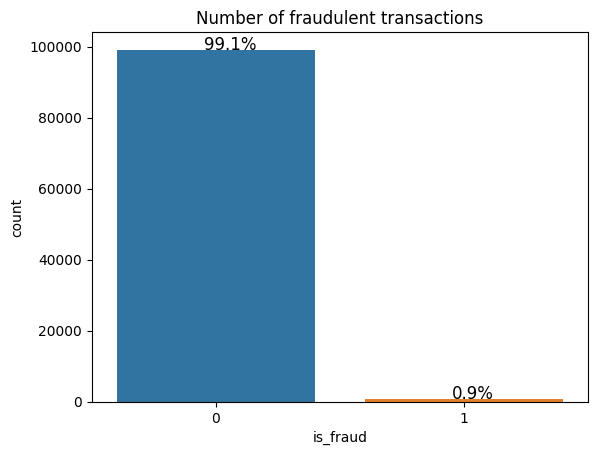

In [14]:
ax = sns.countplot(x='is_fraud',data=cc_clean)
plt.title("Number of fraudulent transactions")

def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
        
without_hue(ax, cc_clean['is_fraud'])

print('Number of transactions:')
cc_clean['is_fraud'].value_counts()

<AxesSubplot:xlabel='gender', ylabel='count'>

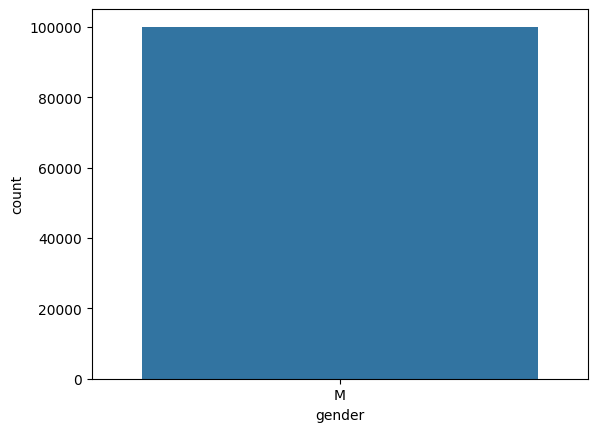

In [15]:
sns.countplot(x='gender',data=cc_clean)

Text(0.5, 1.0, 'Transactions by category')

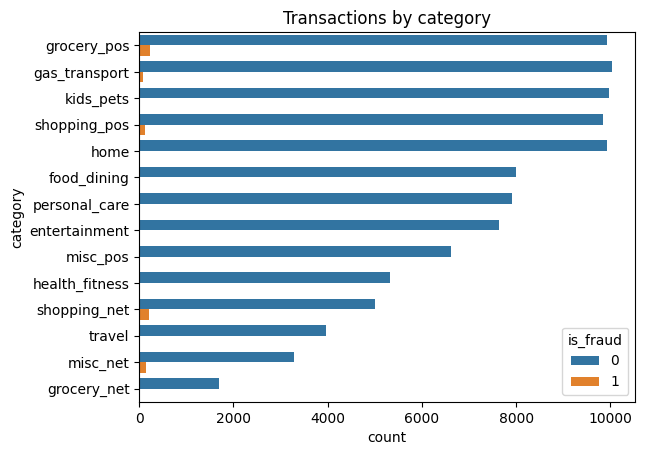

In [16]:
sns.countplot(y='category',hue= 'is_fraud',data=cc_clean, order = cc_clean['category'].value_counts().index)
plt.title('Transactions by category')

[Text(0.5, 1.0, 'Fraudulent transactions by category')]

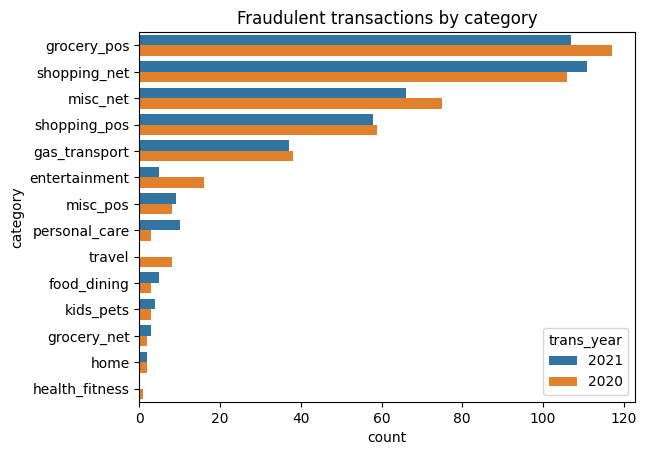

In [17]:
sns.countplot(y='category',hue= 'trans_year',data=cc_clean[cc_clean['is_fraud'] == 1],
             order = cc_clean[cc_clean['is_fraud'] == 1]['category'].value_counts().index).set(
    title = 'Fraudulent transactions by category')



[Text(0.5, 1.0, 'Fraudulent transactions by Job')]

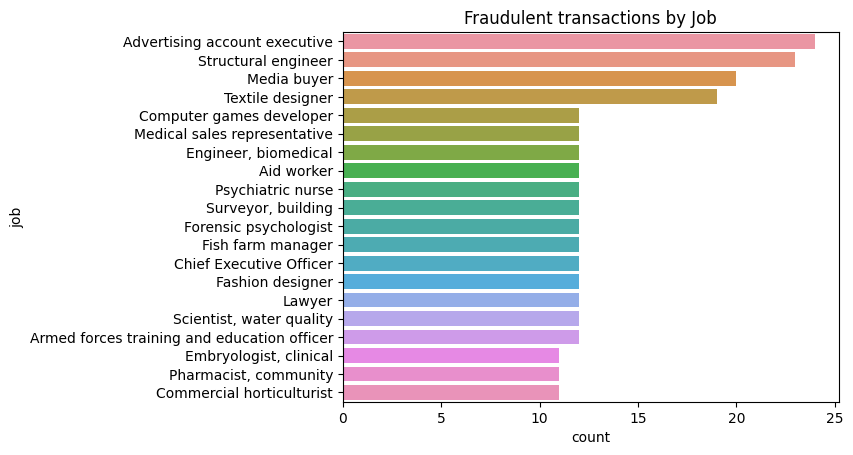

In [18]:
sns.countplot(y='job', data=cc_clean[cc_clean['is_fraud'] == 1],
            order = cc_clean[cc_clean['is_fraud'] == 1]['job'].value_counts().iloc[:20].index).set(
    title = 'Fraudulent transactions by Job'
)           

[Text(0.5, 1.0, 'Fraudulent transactions by merchant')]

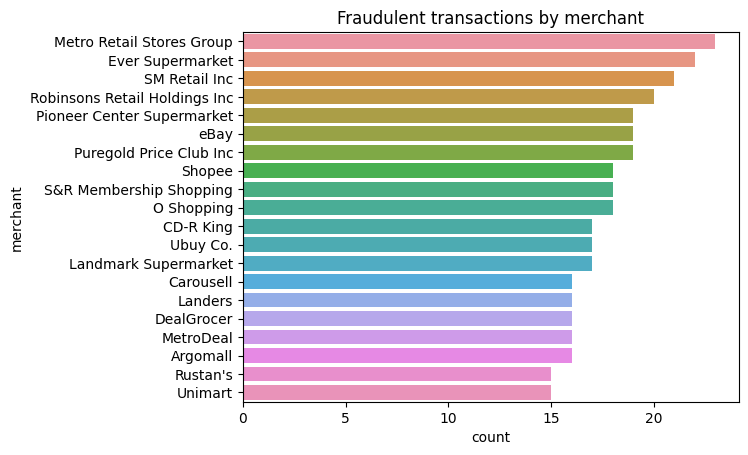

In [19]:
sns.countplot(y='merchant', data=cc_clean[cc_clean['is_fraud'] == 1],
            order = cc_clean[cc_clean['is_fraud'] == 1]['merchant'].value_counts().iloc[:20].index).set(
    title = 'Fraudulent transactions by merchant'
)            

[Text(0.5, 1.0, 'Amount of fraudulent transactions by merchant')]

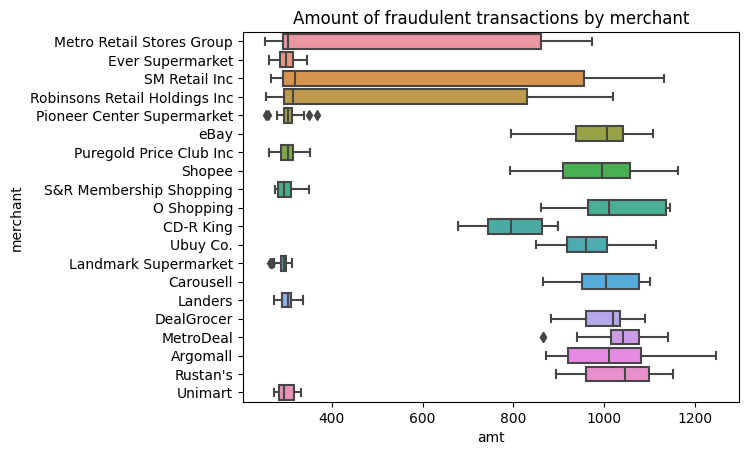

In [20]:
sns.boxplot(y='merchant', x= 'amt',data=cc_clean[cc_clean['is_fraud'] == 1],
                order = cc_clean[cc_clean['is_fraud'] == 1]['merchant'].value_counts().iloc[:20].index).set(
        title = 'Amount of fraudulent transactions by merchant'
    )

In [21]:
top_cat = ['shopping_net', 'grocery_pos', 'misc_net', 'shopping_pos']

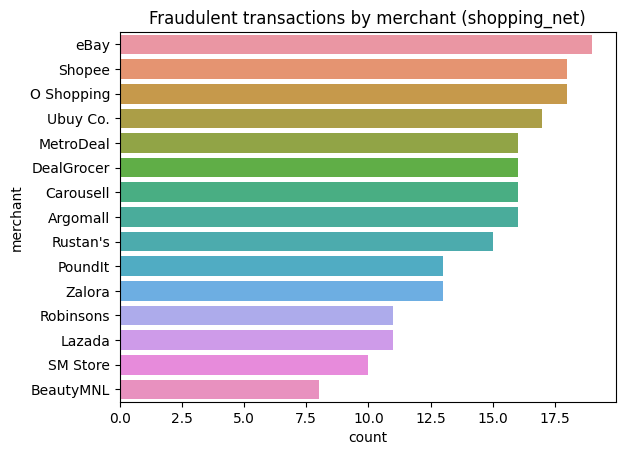

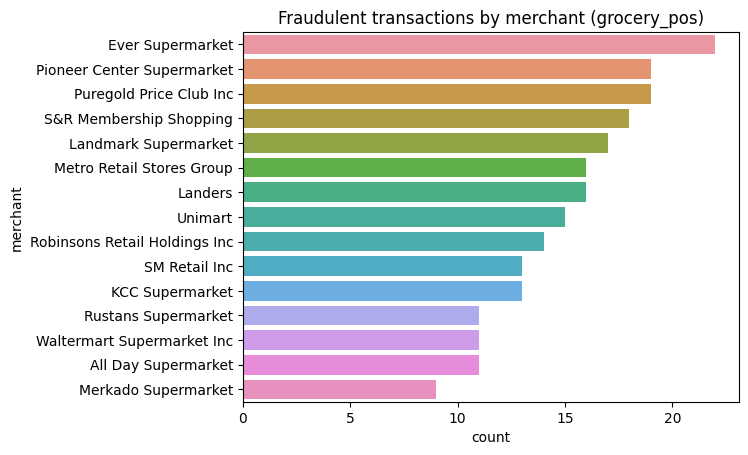

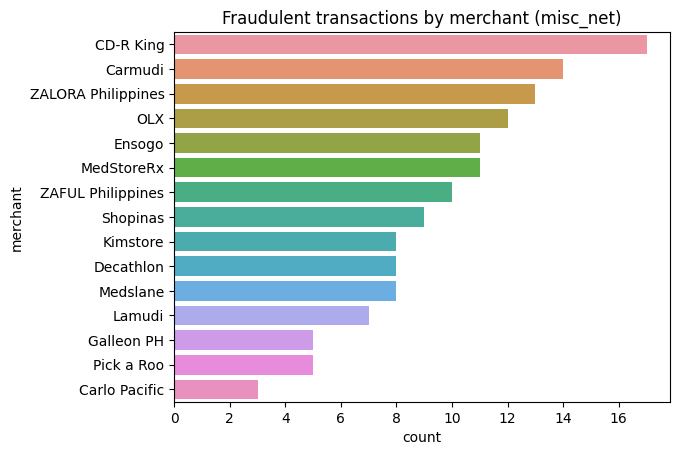

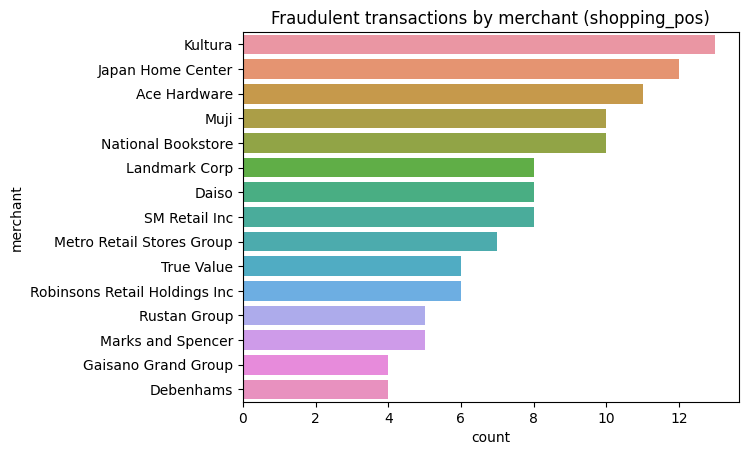

In [22]:
for nm in top_cat:
    temp = cc_clean[(cc_clean['is_fraud'] == 1) & (cc_clean['category'] == nm)]

    sns.countplot(y='merchant',data=temp,
                order = temp['merchant'].value_counts().iloc[:20].index).set(
        title = 'Fraudulent transactions by merchant (' + nm + ')'
    )    

    plt.show()

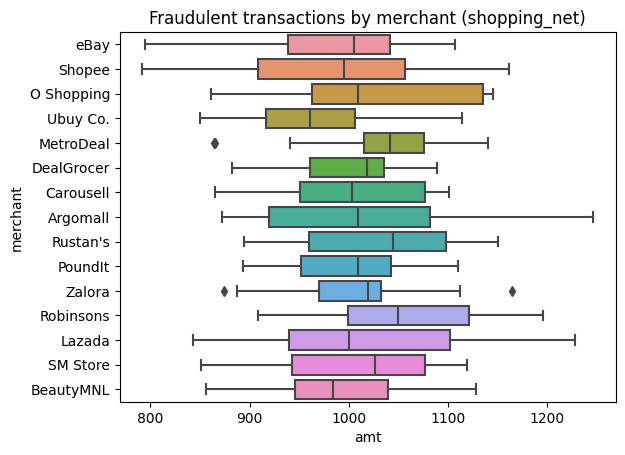

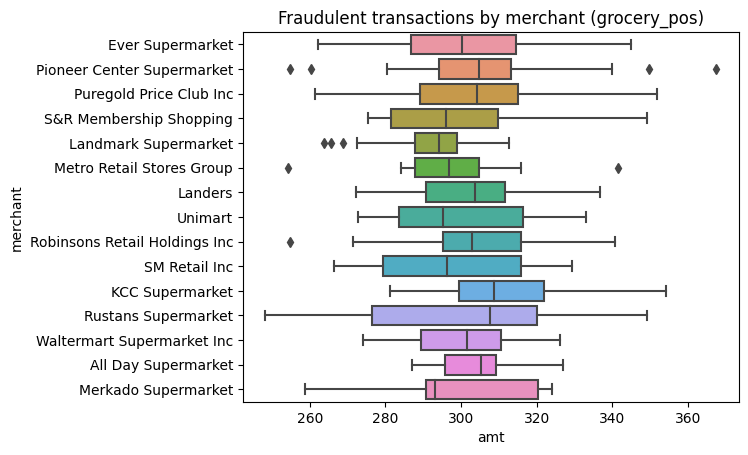

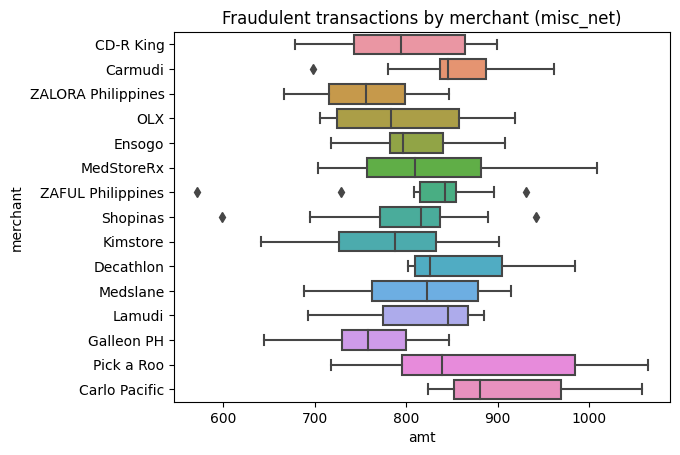

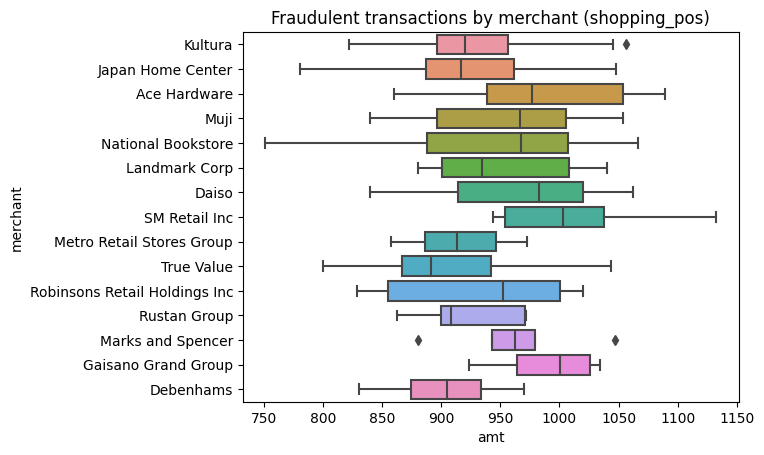

In [23]:
for nm in top_cat:
    temp = cc_clean[(cc_clean['is_fraud'] == 1) & (cc_clean['category'] == nm)]

    sns.boxplot(y='merchant', x= 'amt',data=temp,
                order = temp['merchant'].value_counts().iloc[:20].index).set(
        title = 'Fraudulent transactions by merchant (' + nm + ')'
    )

    plt.show()

[Text(0.5, 1.0, 'Fraudulent transactions by category')]

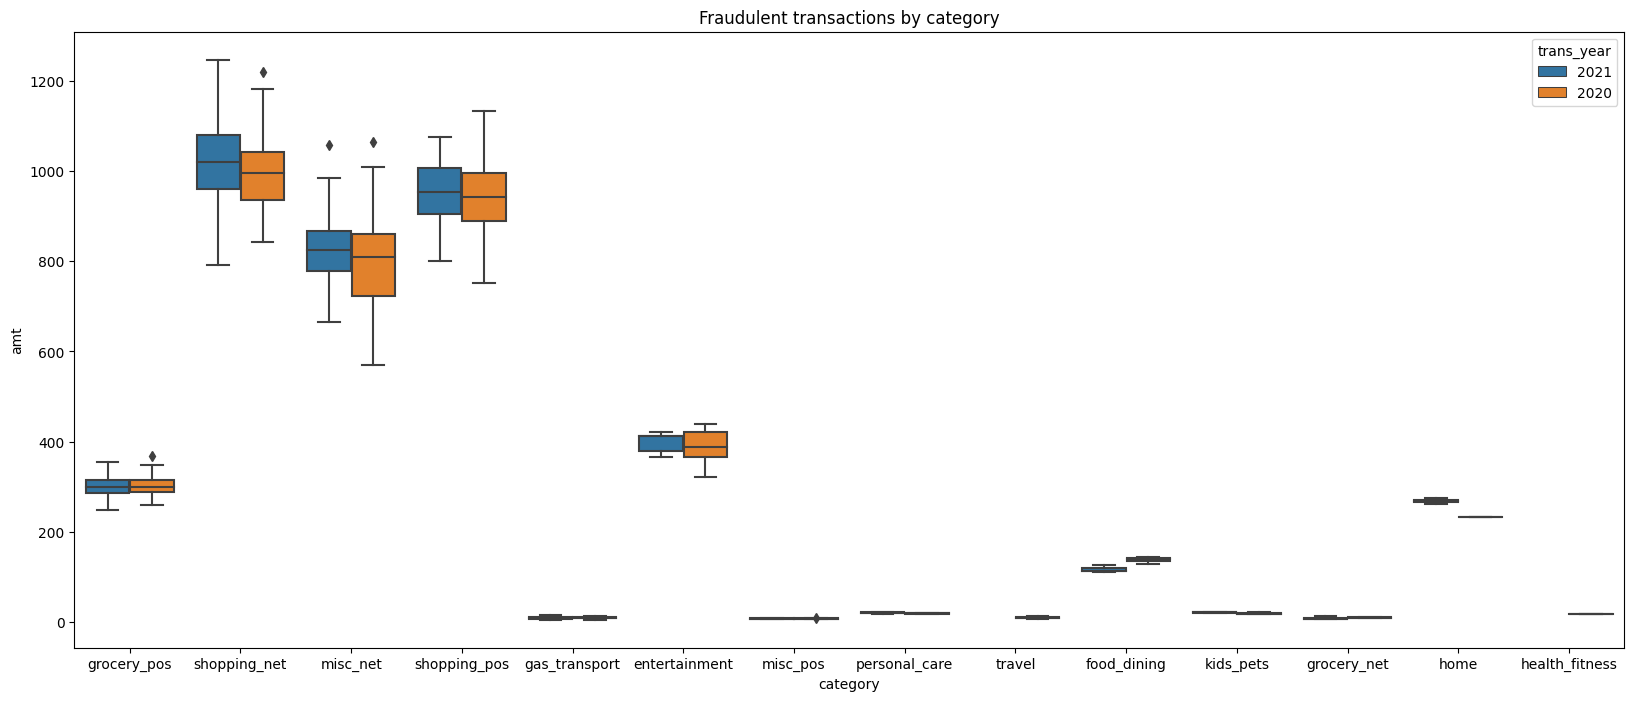

In [24]:
plt.figure(figsize=(20,8))

sns.boxplot(x='category', y= 'amt', hue= 'trans_year',data=cc_clean[cc_clean['is_fraud'] == 1],
             order = cc_clean[cc_clean['is_fraud'] == 1]['category'].value_counts().index).set(
    title = 'Fraudulent transactions by category'
)       

[Text(0.5, 1.0, 'Transactions per month')]

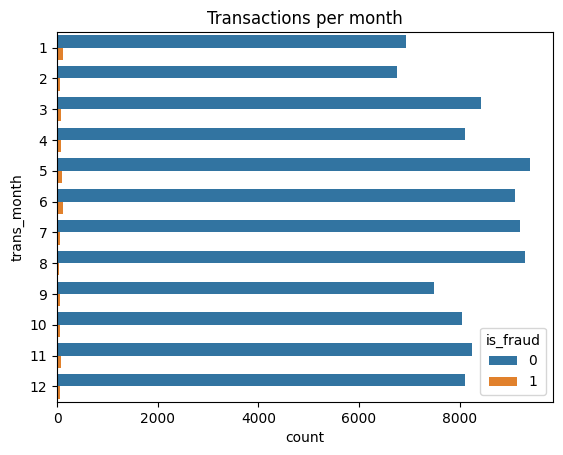

In [25]:
sns.countplot(y='trans_month',hue= 'is_fraud',data=cc_clean).set(title ='Transactions per month')

[Text(0.5, 1.0, 'Number of Fraud Transactions per Month')]

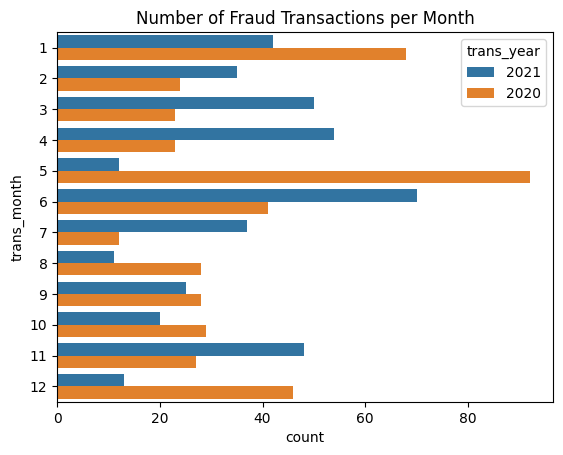

In [26]:
sns.countplot(y='trans_month',hue= 'trans_year',data=cc_clean[cc_clean['is_fraud'] == 1]).set(title = 'Number of Fraud Transactions per Month')

In [27]:
mem_summary = cc_clean[['full_name', 'is_fraud', 'trans_year']]
mem_transactions = pd.DataFrame(mem_summary.groupby(['full_name']).count()['is_fraud']).reset_index()
mem_transactions = mem_transactions.rename(columns={"is_fraud":"trans_count"})

In [28]:
mem_fraud_cnt = pd.DataFrame(mem_summary[mem_summary['is_fraud'] == 1].groupby(['full_name']).count()['is_fraud']).reset_index()
mem_fraud_cnt = mem_fraud_cnt.rename(columns={"is_fraud":"fraud_count"})

In [29]:
mem_trans_cnt = mem_transactions.merge(mem_fraud_cnt, on = 'full_name', how = 'outer')
mem_trans_cnt['perc_fraud'] = 100*(mem_trans_cnt['fraud_count']/mem_trans_cnt['trans_count'])
mem_trans_cnt['w_fraud'] = np.where(mem_trans_cnt['fraud_count']>0, 1, 0)
mem_trans_cnt

,full_name,trans_count,fraud_count,perc_fraud,w_fraud
0,Aaron Chase,2102,9.0,0.428164,1
1,Aaron Suarez,1415,10.0,0.706714,1
2,Aaron Walker,10,10.0,100.000000,1
3,Alex Alexander,1415,8.0,0.565371,1
4,Alexander Brown,12,12.0,100.000000,1
...,...,...,...,...,...
85,Thomas Turner,12,12.0,100.000000,1
86,Todd Eaton,1419,12.0,0.845666,1
87,Todd Smith,707,7.0,0.990099,1
88,Tom Patterson,714,12.0,1.680672,1


Average number of transactions per person: 1111.11
Minimum number of transactions: 8
Maximum number of transactions: 2126

Number of people with all fraud transactions: 19
Minimum fraud transaction count (all_fraud): 8.0
Maximum fraud transaction count (all_fraud): 12.0


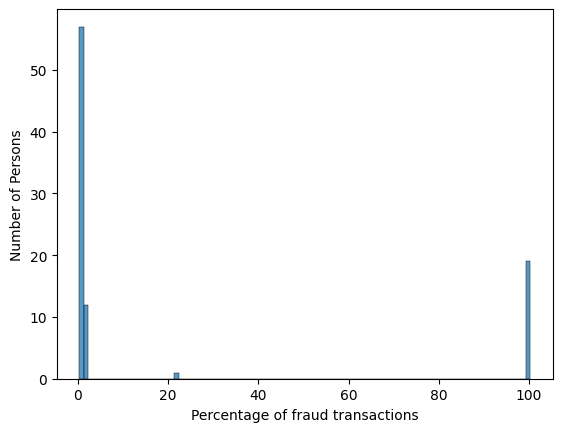

In [30]:
sns.histplot(data = mem_trans_cnt, x = 'perc_fraud', binwidth = 1)
plt.xlabel('Percentage of fraud transactions')
plt.ylabel('Number of Persons')

print ("Average number of transactions per person:", round(np.mean(mem_trans_cnt['trans_count']),2))
print ("Minimum number of transactions:", min(mem_trans_cnt['trans_count']))
print ("Maximum number of transactions:", max(mem_trans_cnt['trans_count']))

all_fraud_mems = mem_trans_cnt[mem_trans_cnt['perc_fraud'] == 100]
print ("\nNumber of people with all fraud transactions:", len(all_fraud_mems))
print ("Minimum fraud transaction count (all_fraud):", min(all_fraud_mems['fraud_count']))
print ("Maximum fraud transaction count (all_fraud):", max(all_fraud_mems['fraud_count']))

Number of people with less than 50% fraud transactions: 70
Max percentage(%) of fraud transactions: 21.57


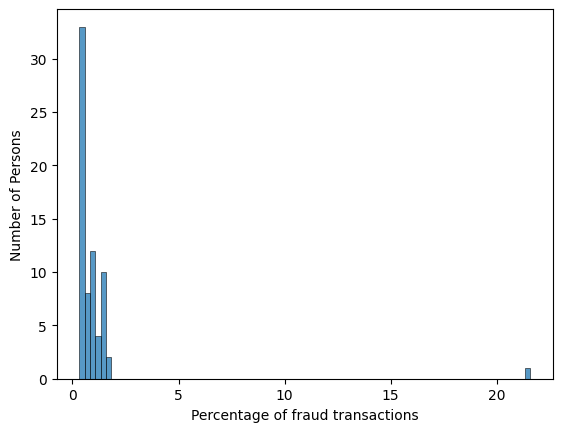

In [31]:
less_50_perc_fraud = mem_trans_cnt[mem_trans_cnt['perc_fraud'] < 50]
sns.histplot(data = less_50_perc_fraud, x = 'perc_fraud', binwidth = 0.25)
plt.xlabel('Percentage of fraud transactions')
plt.ylabel('Number of Persons')

print ("Number of people with less than 50% fraud transactions:", len(less_50_perc_fraud))
print ("Max percentage(%) of fraud transactions:", round(max(less_50_perc_fraud['perc_fraud']), 2))

Text(0.5, 1.0, 'Number of individuals with fraud transactions')

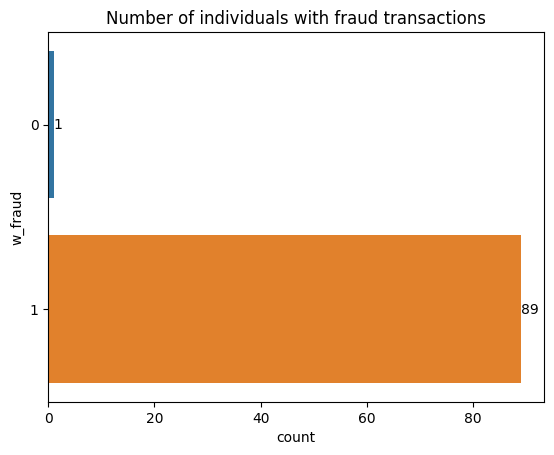

In [32]:
ax =sns.countplot(y='w_fraud',data=mem_trans_cnt)
ax.bar_label(ax.containers[0])
plt.title('Number of individuals with fraud transactions')

#### Account exploration

In [33]:
print(cc_clean['acct_num'].nunique())
print(cc_clean['full_name'].nunique())
print(cc_clean['cc_num'].nunique())

90
90
90


In [34]:
cc_clean[['full_name', 'acct_num', 'cc_num']].drop_duplicates()

,full_name,acct_num,cc_num
0,Steve Williams,3.828640e+11,3.576610e+15
2095,Michael Williams,4.664670e+11,3.000530e+13
2809,John Tyler,9.104880e+11,3.715450e+14
4224,Nicholas Davis,5.583160e+11,5.810100e+11
4234,Christopher Craig,8.392670e+11,3.002390e+13
...,...,...,...
95694,Edward Coleman,4.354500e+11,3.558900e+15
97113,Ryan Mitchell,9.989010e+11,4.406080e+15
97822,Jason Campbell,7.981890e+11,3.789770e+14
98534,Ryan Fields,6.262210e+11,3.053950e+13


In [35]:
cc_clean[['full_name', 'acct_num', 'cc_num', 'trans_num', 'is_fraud']].groupby(['full_name', 'acct_num', 'cc_num', 'is_fraud']).count()

trans_num
full_name     acct_num     cc_num       is_fraud           
Aaron Chase   1.960530e+11 3.481480e+14 0              2093
                                        1                 9
Aaron Suarez  6.390250e+11 4.771960e+12 0              1405
                                        1                10
Aaron Walker  6.957000e+11 3.502010e+15 1                10
...                                                     ...
Todd Smith    7.093260e+11 6.554940e+15 1                 7
Tom Patterson 8.178700e+11 2.276000e+15 0               702
                                        1                12
Tristan Kirby 1.334290e+11 3.815670e+13 0               704
                                        1                 9

[160 rows x 1 columns]

### Time between transactions

In [36]:
## formatting full_datetime
transaction_dt = cc_clean[['full_name', 'acct_num', 'cc_num', 'trans_num', 'is_fraud', 'trans_date', 'trans_time']].sort_values(['full_name', 'trans_date', 'trans_time'])
transaction_dt['full_datetime'] = pd.to_datetime(pd.to_datetime(transaction_dt['trans_date'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d') + transaction_dt['trans_time'], format='%Y-%m-%d%H:%M:%S')
transaction_dt.head()

,full_name,acct_num,cc_num,trans_num,is_fraud,trans_date,trans_time,full_datetime
50031,Aaron Chase,1.960530e+11,3.481480e+14,4f8a962f3dddc9f7e38511742f94f5c6,0,2020-01-01,22:20:55,2020-01-01 22:20:55
50792,Aaron Chase,1.960530e+11,3.481480e+14,d6f7186ff825d376de337b0736a8df51,0,2020-01-02,05:58:15,2020-01-02 05:58:15
50148,Aaron Chase,1.960530e+11,3.481480e+14,d369c21bde01d8936664b60ffe249966,0,2020-01-02,06:20:53,2020-01-02 06:20:53
50332,Aaron Chase,1.960530e+11,3.481480e+14,449355d3afc7fbc8a0a9c4331b01baa0,0,2020-01-02,19:30:42,2020-01-02 19:30:42
50709,Aaron Chase,1.960530e+11,3.481480e+14,99aa7b2fd8e3f8ed852fcd2736523ec4,0,2020-01-02,21:16:56,2020-01-02 21:16:56


In [37]:
# getting the first transaction per person
min_datetime = pd.DataFrame(transaction_dt.groupby(['full_name'])['full_datetime'].min()).reset_index()
min_datetime = min_datetime.rename(columns={'full_datetime':'min_datetime'})
min_datetime.shape

(90, 2)

In [38]:
## get time between transactions (regardless of fraud status)
transaction_dt = transaction_dt.merge(min_datetime, how = 'left', on = 'full_name')
transaction_dt['lagged_datetime'] = transaction_dt.groupby(['full_name'])['full_datetime'].shift(1)
transaction_dt['diff_datetime'] = (transaction_dt['full_datetime'] -transaction_dt['lagged_datetime'])
transaction_dt['diff_datetime_hrs'] = transaction_dt['diff_datetime'].astype('timedelta64[h]')
transaction_dt

,full_name,acct_num,cc_num,trans_num,is_fraud,trans_date,trans_time,full_datetime,min_datetime,lagged_datetime,diff_datetime,diff_datetime_hrs
0,Aaron Chase,1.960530e+11,3.481480e+14,4f8a962f3dddc9f7e38511742f94f5c6,0,2020-01-01,22:20:55,2020-01-01 22:20:55,2020-01-01 22:20:55,NaT,NaT,NaN
1,Aaron Chase,1.960530e+11,3.481480e+14,d6f7186ff825d376de337b0736a8df51,0,2020-01-02,05:58:15,2020-01-02 05:58:15,2020-01-01 22:20:55,2020-01-01 22:20:55,0 days 07:37:20,7.0
2,Aaron Chase,1.960530e+11,3.481480e+14,d369c21bde01d8936664b60ffe249966,0,2020-01-02,06:20:53,2020-01-02 06:20:53,2020-01-01 22:20:55,2020-01-02 05:58:15,0 days 00:22:38,0.0
3,Aaron Chase,1.960530e+11,3.481480e+14,449355d3afc7fbc8a0a9c4331b01baa0,0,2020-01-02,19:30:42,2020-01-02 19:30:42,2020-01-01 22:20:55,2020-01-02 06:20:53,0 days 13:09:49,13.0
4,Aaron Chase,1.960530e+11,3.481480e+14,99aa7b2fd8e3f8ed852fcd2736523ec4,0,2020-01-02,21:16:56,2020-01-02 21:16:56,2020-01-01 22:20:55,2020-01-02 19:30:42,0 days 01:46:14,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Tristan Kirby,1.334290e+11,3.815670e+13,291c80502ee368630aab3a304092abcd,0,2021-12-07,13:15:21,2021-12-07 13:15:21,2020-01-02 16:26:18,2021-12-06 09:12:55,1 days 04:02:26,28.0
99996,Tristan Kirby,1.334290e+11,3.815670e+13,f553f9399f2d51862f4caaa0549cea4d,0,2021-12-07,17:35:47,2021-12-07 17:35:47,2020-01-02 16:26:18,2021-12-07 13:15:21,0 days 04:20:26,4.0
99997,Tristan Kirby,1.334290e+11,3.815670e+13,1cddbde4ad69eef5eb3be9e892948662,0,2021-12-09,22:37:17,2021-12-09 22:37:17,2020-01-02 16:26:18,2021-12-07 17:35:47,2 days 05:01:30,53.0
99998,Tristan Kirby,1.334290e+11,3.815670e+13,0743a0401e9a32ad0445d9be1542d0bf,0,2021-12-10,23:44:56,2021-12-10 23:44:56,2020-01-02 16:26:18,2021-12-09 22:37:17,1 days 01:07:39,25.0


[Text(0.5, 1.0, 'time between previous transaction')]

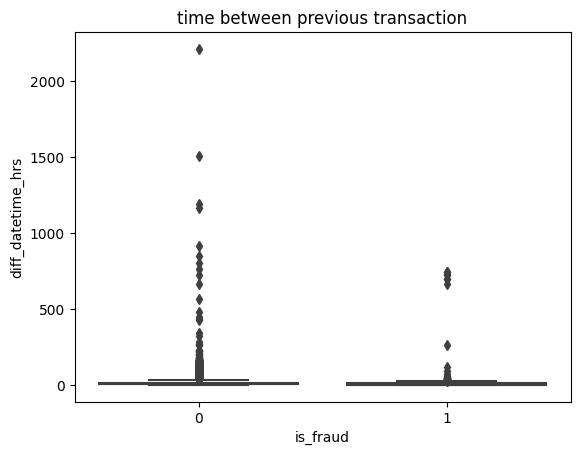

In [39]:
sns.boxplot(y='diff_datetime_hrs', x= 'is_fraud',data=transaction_dt,
                # order = temp['merchant'].value_counts().iloc[:20].index)
    ).set(title = 'time between previous transaction')

[Text(0.5, 1.0, 'time between previous transaction (within 48 hours)')]

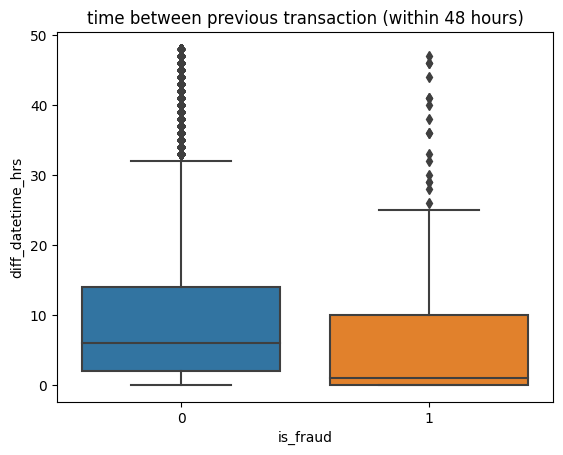

In [40]:
sns.boxplot(y='diff_datetime_hrs', x= 'is_fraud',data=transaction_dt[transaction_dt['diff_datetime_hrs'] <= 48],
                # order = temp['merchant'].value_counts().iloc[:20].index)
    ).set(title = 'time between previous transaction (within 48 hours)')

In [41]:
## fraud times
fraud_dt = transaction_dt[transaction_dt['is_fraud']==1]
fraud_dt['fraud_num'] = fraud_dt.groupby('full_name').cumcount()+1
fraud_dt['lagged_datetime'] = fraud_dt.groupby(['full_name'])['full_datetime'].shift(1)
fraud_dt['diff_datetime'] = (fraud_dt['full_datetime'] -fraud_dt['lagged_datetime'])
fraud_dt

,full_name,acct_num,cc_num,trans_num,is_fraud,trans_date,trans_time,full_datetime,min_datetime,lagged_datetime,diff_datetime,diff_datetime_hrs,fraud_num
1046,Aaron Chase,1.960530e+11,3.481480e+14,a48ce3478aae3e6ce858bdac8466f13f,1,2020-12-19,11:13:43,2020-12-19 11:13:43,2020-01-01 22:20:55,NaT,NaT,17.0,1
1047,Aaron Chase,1.960530e+11,3.481480e+14,26362d5836d688ba3cc2e3129dc2f7f7,1,2020-12-19,20:56:49,2020-12-19 20:56:49,2020-01-01 22:20:55,2020-12-19 11:13:43,0 days 09:43:06,9.0,2
1048,Aaron Chase,1.960530e+11,3.481480e+14,b6310f84f8cb0c7f40cf7ae27b8707b0,1,2020-12-19,22:15:42,2020-12-19 22:15:42,2020-01-01 22:20:55,2020-12-19 20:56:49,0 days 01:18:53,1.0,3
1049,Aaron Chase,1.960530e+11,3.481480e+14,72220867c589de87c0a57b704757b6b1,1,2020-12-19,22:52:44,2020-12-19 22:52:44,2020-01-01 22:20:55,2020-12-19 22:15:42,0 days 00:37:02,0.0,4
1050,Aaron Chase,1.960530e+11,3.481480e+14,42cb04322451fc3fa98461d083045fbc,1,2020-12-20,03:23:30,2020-12-20 03:23:30,2020-01-01 22:20:55,2020-12-19 22:52:44,0 days 04:30:46,4.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99695,Tristan Kirby,1.334290e+11,3.815670e+13,a6a01e90437caddea6e24e8d5d533011,1,2021-01-19,18:53:29,2021-01-19 18:53:29,2020-01-02 16:26:18,2021-01-19 02:52:42,0 days 16:00:47,16.0,5
99696,Tristan Kirby,1.334290e+11,3.815670e+13,eea0b97fc756f58b7878e593eba82c0c,1,2021-01-19,22:37:12,2021-01-19 22:37:12,2020-01-02 16:26:18,2021-01-19 18:53:29,0 days 03:43:43,3.0,6
99697,Tristan Kirby,1.334290e+11,3.815670e+13,9da7c5795cca2c8a5c4e067c0ea473a2,1,2021-01-19,22:47:14,2021-01-19 22:47:14,2020-01-02 16:26:18,2021-01-19 22:37:12,0 days 00:10:02,0.0,7
99698,Tristan Kirby,1.334290e+11,3.815670e+13,15a434fd3e6e16fc705121f51eb91fd3,1,2021-01-19,22:56:51,2021-01-19 22:56:51,2020-01-02 16:26:18,2021-01-19 22:47:14,0 days 00:09:37,0.0,8


In [42]:
print("Number of people in data: " + str(transaction_dt['full_name'].nunique()))
print("Number of people with fraud transactions: " + str(fraud_dt['full_name'].nunique()))

Number of people in data: 90
Number of people with fraud transactions: 89


In [43]:
# time to first fraud
first_fraud = fraud_dt[fraud_dt['fraud_num']==1]
first_fraud['time_to_first_fraud'] = fraud_dt['full_datetime'] - fraud_dt['min_datetime']
first_fraud['diff_datetime_days'] = first_fraud['time_to_first_fraud'].astype('timedelta64[D]')
first_fraud

,full_name,acct_num,cc_num,trans_num,is_fraud,trans_date,trans_time,full_datetime,min_datetime,lagged_datetime,diff_datetime,diff_datetime_hrs,fraud_num,time_to_first_fraud,diff_datetime_days
1046,Aaron Chase,1.960530e+11,3.481480e+14,a48ce3478aae3e6ce858bdac8466f13f,1,2020-12-19,11:13:43,2020-12-19 11:13:43,2020-01-01 22:20:55,NaT,NaT,17.0,1,352 days 12:52:48,352.0
2315,Aaron Suarez,6.390250e+11,4.771960e+12,7138b1ac12c5632df9322cea9a15cb2b,1,2020-05-09,00:59:42,2020-05-09 00:59:42,2020-01-01 00:14:12,NaT,NaT,15.0,1,129 days 00:45:30,129.0
3517,Aaron Walker,6.957000e+11,3.502010e+15,25d4a172d0ab8f9decdff3b22bf38373,1,2021-03-16,02:09:49,2021-03-16 02:09:49,2021-03-16 02:09:49,NaT,NaT,NaN,1,0 days 00:00:00,0.0
3802,Alex Alexander,1.722280e+11,6.759360e+11,e0c34cd3145c158f18ee1567d899ebeb,1,2020-05-30,14:09:37,2020-05-30 14:09:37,2020-01-01 12:25:05,NaT,NaT,23.0,1,150 days 01:44:32,150.0
4942,Alexander Brown,8.972400e+11,3.546570e+15,a5a77d2f2b905b7c765a46a57196ba61,1,2021-02-01,03:22:36,2021-02-01 03:22:36,2021-02-01 03:22:36,NaT,NaT,NaN,1,0 days 00:00:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96435,Thomas Turner,8.539200e+11,3.520370e+15,997ad728e873181b426629c9c3a4ee52,1,2021-04-24,01:54:47,2021-04-24 01:54:47,2021-04-24 01:54:47,NaT,NaT,NaN,1,0 days 00:00:00,0.0
97709,Todd Eaton,8.400410e+11,4.631710e+18,553d8d3ef79a86c5c46099c0ac639451,1,2021-09-16,00:21:22,2021-09-16 00:21:22,2020-01-02 23:21:43,NaT,NaT,12.0,1,622 days 00:59:39,622.0
98094,Todd Smith,7.093260e+11,6.554940e+15,acf1c74121ff8bc042196866d2c2fe00,1,2020-08-21,00:22:28,2020-08-21 00:22:28,2020-01-01 09:15:44,NaT,NaT,15.0,1,232 days 15:06:44,232.0
99123,Tom Patterson,8.178700e+11,2.276000e+15,5fbf430ac9469c1ebf68135903262dae,1,2021-06-24,12:31:20,2021-06-24 12:31:20,2020-01-02 06:33:47,NaT,NaT,24.0,1,539 days 05:57:33,539.0


In [44]:
first_fraud_summary = first_fraud.groupby('diff_datetime_days')['trans_num'].count().reset_index().sort_values(['trans_num'], ascending = False)

In [45]:
# convert time to part of day
def group_days(diffday):
    """Return the part of day given the hour of day"""
    if (diffday > 180):
        return '> 6 months'
    elif (diffday <= 180) & (diffday > 60):
        return 'within 6 months'
    elif (diffday <= 60) & (diffday > 30):
        return 'within 2 months'
    elif (diffday <= 30) & (diffday > 1):
        return 'within a month'
    else:
        return 'within a day'

first_fraud_summary['diffdate_cat'] = first_fraud_summary['diff_datetime_days'].apply(group_days)

In [46]:
y = first_fraud_summary.groupby('diffdate_cat')['trans_num'].sum().reset_index()
y

,diffdate_cat,trans_num
0,> 6 months,45
1,within 2 months,3
2,within 6 months,13
3,within a day,20
4,within a month,8


[Text(0.5, 1.0, 'days before first fraud')]

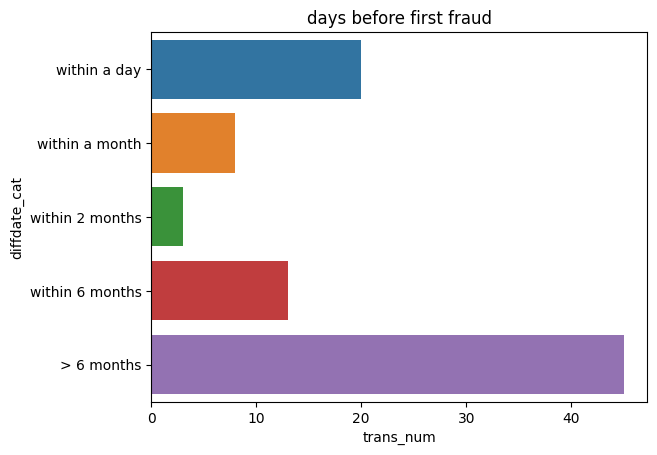

In [47]:
sns.barplot(data = y, y = 'diffdate_cat', x = 'trans_num',
order = ['within a day', 'within a month', 'within 2 months', 'within 6 months', '> 6 months']).set(title = 'days before first fraud')

In [48]:
names = transaction_dt['full_name'].unique()
x = pd.DataFrame()

for nm in names:
    y = transaction_dt[transaction_dt['full_name'] == nm]
    y['seq'] = y['is_fraud'].ne(y['is_fraud'].shift()).cumsum()

    x = pd.concat([x, y])
    # print("sequence col generated for user: " + nm)

In [49]:
# identify sequence of fraud
summary_x = x.groupby(['full_name','is_fraud']).value_counts(['seq']).reset_index()
summary_x = summary_x.rename(columns = {0:'seq_cnt'})
summary_x[summary_x['is_fraud']==1]['seq'].unique()

array([2, 4, 1], dtype=int64)

In [50]:
summary_x.sort_values(['full_name', 'seq']).head(20)

,full_name,is_fraud,seq,seq_cnt
1,Aaron Chase,0,1,1046
2,Aaron Chase,1,2,9
0,Aaron Chase,0,3,1047
4,Aaron Suarez,0,1,213
6,Aaron Suarez,1,2,7
5,Aaron Suarez,0,3,51
7,Aaron Suarez,1,4,3
3,Aaron Suarez,0,5,1141
8,Aaron Walker,1,1,10
10,Alex Alexander,0,1,275


In [51]:
first_fraud = summary_x[summary_x['is_fraud'] == 1].groupby(['full_name'])['seq'].min().reset_index()
first_fraud = first_fraud.merge(summary_x[['full_name', 'seq', 'seq_cnt']], on = ['full_name', 'seq'], how = 'left')
first_fraud.shape

(89, 3)

In [52]:
second_fraud = first_fraud.merge(summary_x[summary_x['is_fraud'] == 1][['full_name','seq', 'seq_cnt']], how='right', on = ['full_name', 'seq', 'seq_cnt'], indicator = True)
second_fraud = second_fraud[second_fraud['_merge'] == 'right_only']
second_fraud.shape

(32, 4)

#### length of fraud streak 

[Text(0.5, 1.0, 'length of first fraud streak')]

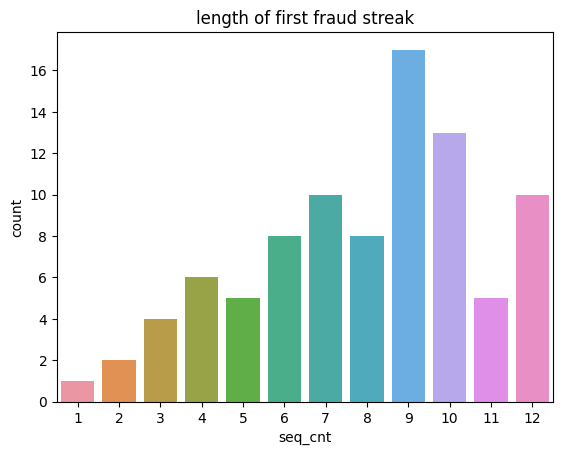

In [53]:
# data = summary_x[(summary_x['is_fraud'] == 1) & (summary_x['seq'] == 1)]
sns.countplot(data = first_fraud, x = 'seq_cnt').set(title = 'length of first fraud streak')

[Text(0.5, 1.0, 'length of second fraud streak')]

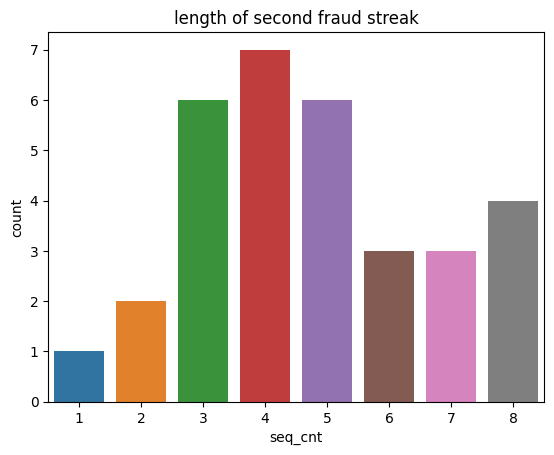

In [54]:
sns.countplot(data = second_fraud, x = 'seq_cnt').set(title = 'length of second fraud streak')

In [55]:
transaction_dt['diff_datetime_days'] = transaction_dt['diff_datetime'].astype('timedelta64[D]')
transaction_dt['diff_datetime_hrs'] = transaction_dt['diff_datetime'].astype('timedelta64[h]')
transaction_dt['diff_datetime_mins'] = transaction_dt['diff_datetime'].astype('timedelta64[m]')

In [56]:
print( "Transactions done within 48 hours after previous: " + str(transaction_dt[transaction_dt['diff_datetime_hrs'] <= 48]['diff_datetime_hrs'].count()))
print( "Transactions done more than 48 hours after previous: " + str(transaction_dt[transaction_dt['diff_datetime_hrs'] > 48]['diff_datetime_hrs'].count()))

Transactions done within 48 hours after previous: 96544
Transactions done more than 48 hours after previous: 3366


In [57]:
print( "valid transactions: " + str(transaction_dt[(transaction_dt['is_fraud'] == 0)]['trans_num'].count()))
print( "fraud transactions: " + str(transaction_dt[(transaction_dt['is_fraud'] == 1)]['trans_num'].count()))

valid transactions: 99142
fraud transactions: 858


<AxesSubplot:>

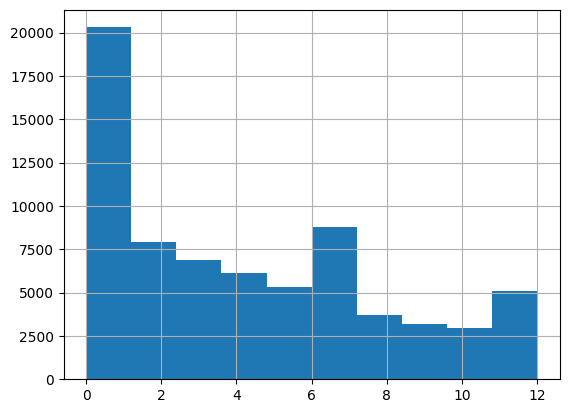

In [58]:
transaction_dt[transaction_dt['diff_datetime_hrs'] <= 12]['diff_datetime_hrs'].hist()

<AxesSubplot:xlabel='transaction before 24hrs', ylabel='count'>

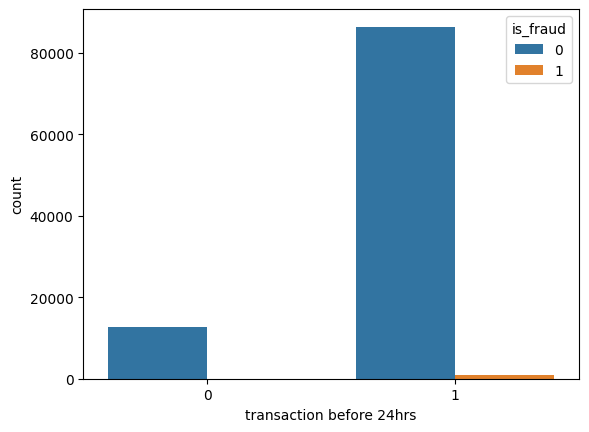

In [59]:
transaction_dt['transaction before 24hrs'] = np.where(transaction_dt['diff_datetime_hrs'] <= 24, 1, 0)
sns.countplot(data = transaction_dt, x = 'transaction before 24hrs', hue = 'is_fraud')

In [60]:
# convert time to part of day
def get_hr_between_trans(hour):
    """Return the part of day given the hour of day"""
    if (hour > 24):
        return '> 24hrs'
    elif (hour <= 24) & (hour > 12):
        return '> 12hrs'
    elif (hour <= 12) & (hour > 6):
        return '> 6hrs'
    elif (hour <= 6) & (hour > 3):
        return '> 3hrs'
    elif (hour <= 3) & (hour > 1):
        return '> 1hr'
    else:
        return '<= 1hr'

transaction_dt['hrs_cat'] = transaction_dt['diff_datetime_hrs'].apply(get_hr_between_trans)

<AxesSubplot:xlabel='hrs_cat', ylabel='count'>

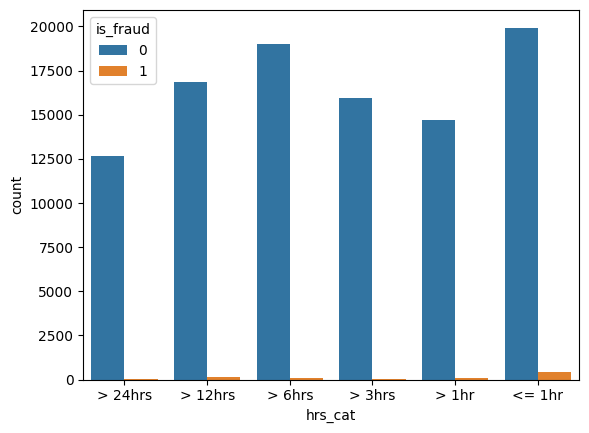

In [61]:
sns.countplot(data = transaction_dt, x = 'hrs_cat', hue = 'is_fraud',
order = ['> 24hrs', '> 12hrs', '> 6hrs', '> 3hrs','> 1hr', '<= 1hr'])

#### Transaction category on streaks

In [62]:
fraud_info = x[(x['is_fraud'] == 1)]
first_fraud_info = fraud_info.groupby(['full_name','seq'])['full_datetime'].min().reset_index()\
    .merge(fraud_info[['full_name', 'full_datetime', 'trans_num']], on = ['full_name', 'full_datetime'], how = 'left')

In [63]:
first_fraud_info = first_fraud_info.merge(cc_fraud[['full_name', 'trans_num', 'category', 'merchant', 'amt']], on =['full_name','trans_num'], how = 'left')
first_fraud_info


,full_name,seq,full_datetime,trans_num,category,merchant,amt
0,Aaron Chase,2,2020-12-19 11:13:43,a48ce3478aae3e6ce858bdac8466f13f,grocery_pos,Robinsons Retail Holdings Inc,293.73
1,Aaron Suarez,2,2020-05-09 00:59:42,7138b1ac12c5632df9322cea9a15cb2b,gas_transport,Petron Corporation,10.74
2,Aaron Suarez,4,2020-06-09 02:29:41,848f290bcc7cf95c9f21a636af45c255,grocery_pos,Metro Retail Stores Group,286.11
3,Aaron Walker,1,2021-03-16 02:09:49,25d4a172d0ab8f9decdff3b22bf38373,gas_transport,Jetti Petroleum Inc.,10.42
4,Alex Alexander,2,2020-05-30 14:09:37,e0c34cd3145c158f18ee1567d899ebeb,home,Pacific Paint Philippines Inc,232.48
...,...,...,...,...,...,...,...
116,Thomas Turner,1,2021-04-24 01:54:47,997ad728e873181b426629c9c3a4ee52,grocery_pos,Landmark Supermarket,268.87
117,Todd Eaton,2,2021-09-16 00:21:22,553d8d3ef79a86c5c46099c0ac639451,gas_transport,Phoenix Petroleum,7.73
118,Todd Smith,2,2020-08-21 00:22:28,acf1c74121ff8bc042196866d2c2fe00,grocery_pos,Robinsons Retail Holdings Inc,308.16
119,Tom Patterson,2,2021-06-24 12:31:20,5fbf430ac9469c1ebf68135903262dae,misc_net,Ensogo,782.56


[Text(0.5, 1.0, 'First transaction in fraud streak by category')]

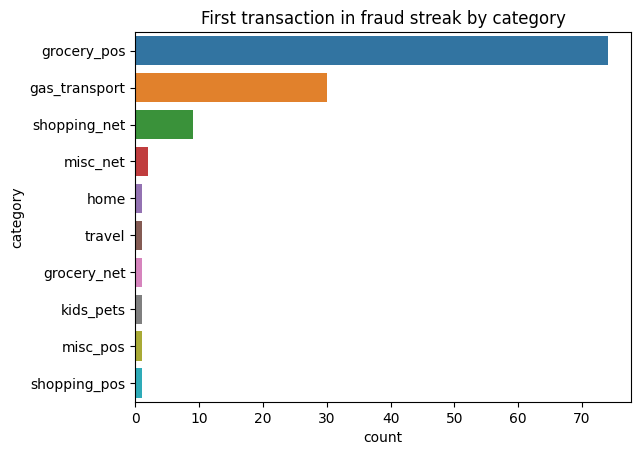

In [64]:
sns.countplot(y='category',data=first_fraud_info, 
order = first_fraud_info['category'].value_counts().index).set(title ='First transaction in fraud streak by category')

[Text(0.5, 1.0, 'First fraud transaction in streak by merchant (top20)')]

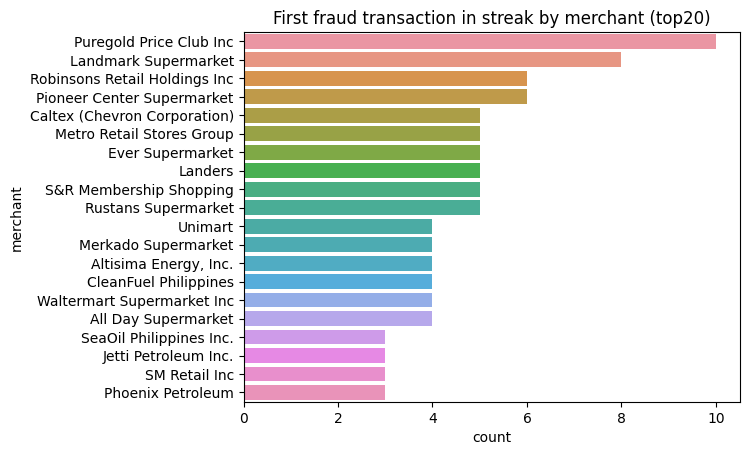

In [65]:
sns.countplot(y='merchant',data=first_fraud_info, 
order = first_fraud_info['merchant'].value_counts().iloc[:20].index).set(title ='First fraud transaction in streak by merchant (top20)')

#### transaction before fraud

In [66]:
mem_wfraud = x[(x['is_fraud'] == 1)]['full_name'].unique()

temp = x[['full_name','trans_num', 'is_fraud']]
temp['is_fraud_lead'] = temp['is_fraud'].shift(-1) 
trans_b4_fraud = temp.merge(cc_fraud[['full_name', 'trans_num', 'category', 'merchant', 'amt']], on =['full_name','trans_num'], how = 'left')
trans_b4_fraud = trans_b4_fraud[(trans_b4_fraud['is_fraud'] == 0) & (trans_b4_fraud['is_fraud_lead'] == 1)]

[Text(0.5, 1.0, 'Transaction before fraud streak by category')]

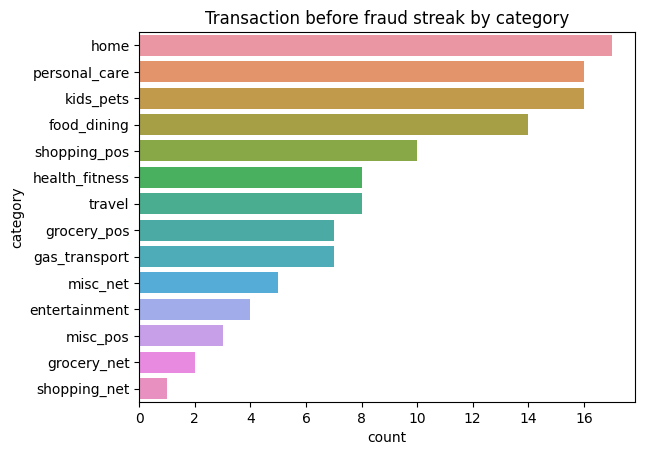

In [67]:
sns.countplot(y='category',data=trans_b4_fraud, 
order = trans_b4_fraud['category'].value_counts().index).set(title ='Transaction before fraud streak by category')

[Text(0.5, 1.0, 'Transaction before fraud streak (top20)')]

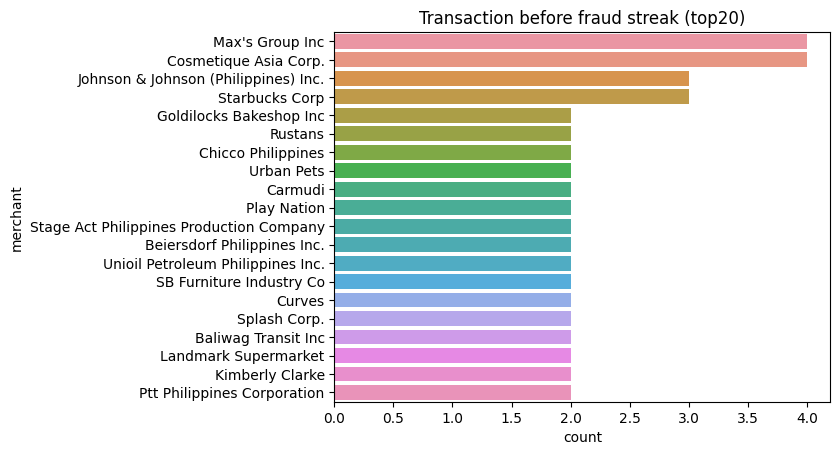

In [68]:
sns.countplot(y='merchant',data=trans_b4_fraud, 
order = trans_b4_fraud['merchant'].value_counts().iloc[:20].index).set(title ='Transaction before fraud streak (top20)')

## Summary of different models

| Model | Parameters Tuned | Best Model Parameters | Accuracy | Run time |
| --- | --- | --- | --: | --- |
| Logistic Regression | Random_state: [1 to 10] <br>Alpha: [1e-11, 1e-10,1e-9,1e-8, 1e-5, 1e-3, 0.1] | Random_state: 10<br> Alpha: 1e-10 | 99.08 | 3 mins 34 secs |
| KNN Classifier | n_neighbors: [2 to 6] <br> data split: train-test split, 5-fold crossvalidation| n_neighbors (train-test split): 2 <br> n_neighbors (crossvalidation): 6 | 99.31 <br> 90.79 | 5mins 38secs* <br>  51mins 54 secs|
| Random Forest | max_depth = [1 to 10] <br>n_estimators = [1 to 10] <br><br> max_depth = [1 to 10]<br>max_features = [60, 80, 100, 120, 140]| max_depth = 7 <br>n_estimators = 1 <br><br> max_depth = 10 <br>max_features = 120 | 99.08<br><br><br>99.19 | 3mins 28secs<br><br><br>16mins 44secs |
| Gradient Boosting | max_depth = [1 to 10] <br>random_state = [1 to 10] <br><br> n_estimators = [1 to 99] <br> random_state = [1 to 10] | max_depth = 8 <br><br> n_estimators = 8 <br> |  99.51  <br><br><br> 99.56  | 40 mins 6 secs  <br><br><br> 35 mins 36 secs  |
| Ada Boosting | n_estimators = [1 to 10]<br>random_state = [1 to 10]<br>**tried learning rate, interestingly accuracy is terrible (<1%)| n_estimators = 7<br>random_state = 7 | 99.77 | 10 minutes 47 seconds |
| ExtraTreesBoosting | max_depth = [1 to 10] <br> n_estimators = 100 <br> random_state = [1 to 10]| max_depth = --- <br> n_estimators = 100 <br> random_state = --- | 99.05 | 23 minutes 40.3 seconds |
###### * fitted on 10,000 rows only. fitting on 100,000 rows takes more than 2hrs then crashes 


## Interesting insights

**EDA** (based on 500k subset)  
- Less than 1% of all transaction are fraudulent.  
- Majority of the of the fraud transactions are from internet transactions (shopping_net & misc_net) and POS transactions (grocery_pos & shopping_pos)
- There are more fraud transactions in 2021. Interestingly for the month of December all of the fraud transactions were done in 2021 and none in 2020.
- There are individuals where all of their transactions are fraudulent.
- Except for 4 people, every person has at least 1 fraudulent transaction.

**Model Tuning**
- Logistic Regression
  - Found a pattern that accuracy goes constant from alpha: 1e-5  and higher. Tried to go backwards, included smaller numbers and found that the results plateaus  from 1e-13 and lower. Limited the range of alpha from 1e-15 to 0.1 to lessen the runtime. Accuracy is at its best in random_state: 1 and 10.
- Random Forest
  - Training and test accuracies are high on n_estimators 1 to 3 but drops after the 3rd n_estimator and beyond
  - Average training and test accuracy increases from 60 features and reaches maximum accuracy at 120 features.
- Ada Boosting
  - After a set amount of estimators (in this case, 7), accuracy for both test and training plateaus, due to the iterations leading to more accurate estimators that predict examples correctly